In [8]:
from aicsimageio import AICSImage
import numpy as np
import time

a = np.arange(0,70,4)  # Scenes to be imported
a[a==28] = 29
a = np.delete(a, a==48)
a = a.tolist()
timepoint = 6    # t=3 (12h)
cziFile = AICSImage("D:/LSM/2021-06-10/New-01.czi")

cziFile.dask_data
cziFile.xarray_dask_data
cziArr = []
for i in a:
    cziFile.set_scene(int(i)) 
    lazyCurrentScene = cziFile.get_image_dask_data("CYX", T=timepoint)   # Stepwise loading of the image (lazy load)
    currentScene = lazyCurrentScene.compute()    # Execute the loading
    maskedArr = np.ma.array(currentScene)
    cziArr.append(maskedArr)

a = np.arange(1,38,2)  # Scenes to be imported
a = np.delete(a, a==25)
a = a.tolist()
cziFile = AICSImage("D:/LSM/2021-07-06/New-03.czi")
cziFile.dask_data
cziFile.xarray_dask_data

for i in a:
    cziFile.set_scene(int(i)) 
    lazyCurrentScene = cziFile.get_image_dask_data("CYX", T=timepoint)
    currentScene = lazyCurrentScene.compute()
    maskedArr = np.ma.array(currentScene)
    cziArr.append(maskedArr)
del cziFile, currentScene, lazyCurrentScene


In [1]:
import numpy as np
a = np.arange(0,70,4)  # Scenes to be imported
a[a==28] = 29
a = np.delete(a, a==48)
a = a.tolist()
a

[0, 4, 8, 12, 16, 20, 24, 29, 32, 36, 40, 44, 52, 56, 60, 64, 68]

In [9]:
## Applying masks to the images

from skimage import exposure
from skimage.filters import threshold_li
import skimage.morphology as skmorp
from scipy import ndimage as ndi
from copy import copy
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 16})

# fig, ax = plt.subplots(len(cziArr), 6, figsize=(35,90), subplot_kw={'xticks': [], 'yticks': []})

## Colour map ##
# grayCmap = copy(plt.cm.gray)
# grayCmap.set_bad('k')

for i in range(len(cziArr)):
    cziArr[i].mask = np.ma.nomask   # Reset the masks to no mask
    sumImage = np.sum(cziArr[i],axis=0) # Sum of all slices
    sumImage.mask = np.ma.nomask
    # ax[i,0].imshow(sumImage, cmap='gray')
    # ax[i,0].set_ylabel(('# '+str(i+1)), labelpad=20,rotation='horizontal')
    
    ## Contrast enhancement ##
    p2, p98 = np.percentile(sumImage, (2,98)) # 2nd and 98th percentiles of the current image intensities
    imgRescaled = exposure.rescale_intensity(sumImage, in_range=(p2,p98), out_range='dtype') # Rescale the intensities by strecthing the histogram using the intensities between 2-98 percentiles
    imgRescaled = np.ma.array(imgRescaled)
    
    # ax[i,1].imshow(imgRescaled, cmap='gray')
    #not used# imgRescaled = ndi.gaussian_filter(imgRescaled, sigma=1)
    ## Thresholding ##
    thresh = threshold_li(imgRescaled)
    binary = imgRescaled>thresh     # True = The pixels to be used, False = pixels to be masked out (Background)
    # ax[i,2].imshow(binary, interpolation='none', cmap='gray')
    
    ## Binary open ##
    binary2 = skmorp.binary_opening(binary)
    binary2 = skmorp.binary_dilation(binary2)
    # ax[i,3].imshow(binary2, interpolation='none', cmap='gray')
    
    ## Fill holes ##
    binary3 = ndi.binary_fill_holes(binary2)
    binary3 = skmorp.binary_dilation(binary3)
    # ax[i,4].imshow(binary3, interpolation='none', cmap='gray')
    
    ## Apply the mask to the current image stack ##
    invertedMask = np.invert(binary3)  # True => Pixel will be masked, False => Pixel will be shown/used
    cziArr[i].mask = invertedMask
    # imgRescaled.mask = invertedMask  # For showing the masked sum image
    # sumMaskedImage = np.sum(cziArr[i],axis=0)  # Not used # For showing the masked image
    # ax[i,5].imshow(imgRescaled, cmap=grayCmap)

# ax[0,0].set_title('Sum of the slices')
# ax[0,1].set_title('Contrast adjusted sum')
# ax[0,2].set_title('Li thresholding binary mask')
# ax[0,3].set_title('Binary opening + dilation')
# ax[0,4].set_title('Fill holes + dilation')
# ax[0,5].set_title('Mask applied to the sum image')
# fig.tight_layout()
# plt.show()


In [10]:
## Converting the image array to a python list in which each element is an image array (np array)

scenes = np.arange(len(cziArr),dtype=object) #Create an array of class names (experiment groups) corresponding to each scene
scenes[:6] = 'control'
scenes[6:10] = 'diclo1x'
scenes[10:13] = 'doxo05x'
scenes[13:17] = 'doxo025x'
scenes[17:23] = 'control'
scenes[23:29] = 'doxo025x'
scenes[29:] = 'doxo05x'
scenes = scenes.tolist()
imgArray = []
classList = []
shape = cziArr[0].shape
# imgArray becomes a python list with number of elements equal to the number of scenes. Each element is a (dim(y)*dim(x), 33) sized array (corresponds to 1 lambda stack)
# from the time point given by the variable 'timepoint'
for j in range(len(cziArr)):  
    imgArray.append(cziArr[j].reshape(shape[0],(shape[1]*shape[2])).T)
    classList += imgArray[j].shape[0] * [scenes[j]]

# del i, j, cziArr

#imgArr[0][3].shape # 0: 1st scene (well B02), 3: t=3


In [11]:
import pandas as pd
columns = 33 * ['ch']
chNumbers = np.array(np.arange(1,34), dtype='<U8')
for i in range(len(columns)):
    chNumbers[i] = columns[i]+chNumbers[i]
chNumbers = chNumbers.tolist()
df = pd.DataFrame(imgArray[0], columns=chNumbers)
currentScene = []
for i in range(1,len(imgArray)):
    currentScene = pd.DataFrame(imgArray[i], columns=chNumbers)
    df = df.append(currentScene, ignore_index=True)
df['class'] = classList


In [17]:

df = df.dropna()
df = df.astype({'ch1':'int32','ch2':'int32','ch3':'int32','ch4':'int32','ch5':'int32','ch6':'int32','ch7':'int32','ch8':'int32',
               'ch9':'int32','ch10':'int32','ch11':'int32','ch12':'int32','ch13':'int32','ch14':'int32','ch15':'int32','ch16':'int32',
               'ch17':'int32','ch18':'int32','ch19':'int32','ch20':'int32','ch21':'int32','ch22':'int32','ch23':'int32','ch24':'int32',
               'ch25':'int32','ch26':'int32','ch27':'int32','ch28':'int32','ch29':'int32','ch30':'int32','ch31':'int32','ch32':'int32','ch33':'int32'})
df.head(5)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,...,ch25,ch26,ch27,ch28,ch29,ch30,ch31,ch32,ch33,class
74,176,139,33,177,126,78,178,125,131,167,...,49,119,164,70,83,144,26,17,8,control
75,206,138,52,188,128,182,117,62,215,227,...,141,64,135,63,114,97,12,24,9,control
76,184,149,57,249,116,187,151,16,253,172,...,166,115,201,114,119,108,25,45,9,control
77,194,169,24,119,267,133,103,58,140,215,...,108,169,141,45,62,106,66,28,8,control
78,173,279,93,181,119,110,192,59,152,250,...,107,57,210,17,86,141,21,18,15,control


In [13]:
## Creating the intensity matrix and class label vector

X = df.iloc[:,0:33].values  ## X: The matrix that contains the intensity values of each pixel in lambda channels (2 columns * no.of pixels)
y = df.iloc[:,33].values  ## y: Vector containing the class labels (= experiment group names) (1 column * no.of pixels)

# X_std = X

In [14]:
np.save('new0103t6_valueArray_X.npy',X)
np.save('new0103t6_labelArray_y.npy',y)

In [15]:
df.shape

(11475733, 34)

In [1]:
import numpy as np

with open('new0103t3_valueArray_X.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)

with open('new0103t3_labelArray_y.npy', 'rb') as f:
    y = np.load(f, allow_pickle=True)
    
    

In [2]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler(with_std=False).fit_transform(X) # Only centering


In [3]:
## Covariance matrix

mean_vec_std = np.mean(X_std, axis=0)   # With standardization
cov_mat_std = (X_std - mean_vec_std).T.dot((X_std - mean_vec_std)) / (X_std.shape[0]-1)
print('Covariance matrix (Standardized data)\n%s\n' %cov_mat_std)

# mean_vec = np.mean(X, axis=0)   # Without standardization
# cov_mat = (X - mean_vec).T.dot((X - mean_vec)) / (X.shape[0]-1)
# print('Covariance matrix (No standardization)\n%s\n' %cov_mat)

Covariance matrix (Standardized data)
[[1629.10103567  930.4494623  -227.10359112 ...  -69.02495748
  -349.41416099 -201.25766608]
 [ 930.4494623  2734.87763109  853.38927292 ...  162.76100989
   -54.41221318 -119.2149109 ]
 [-227.10359112  853.38927292 3600.07496594 ...  582.97598955
   590.09904951  122.51302313]
 ...
 [ -69.02495748  162.76100989  582.97598955 ... 5350.10014611
  2756.75739451  320.12382049]
 [-349.41416099  -54.41221318  590.09904951 ... 2756.75739451
  3975.27916664  310.92545536]
 [-201.25766608 -119.2149109   122.51302313 ...  320.12382049
   310.92545536   97.18737107]]



In [5]:
import pandas as pd
eig_vals_std, eig_vecs_std = np.linalg.eig(cov_mat_std)
dfPCs = pd.DataFrame(eig_vecs_std[:,0:2], columns=['PC1', 'PC2'])
dfPCs

,PC1,PC2
0,-0.003358,0.014608
1,0.009200,-0.032427
2,0.024939,-0.075080
3,0.038507,-0.112886
4,0.056311,-0.162520
5,0.068289,-0.199165
6,0.085086,-0.240610
7,0.090327,-0.255430
8,0.096844,-0.273184
9,0.102351,-0.298302


In [10]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs_std = [(np.abs(eig_vals_std[i]), eig_vecs_std[:,i]) for i in range(len(eig_vals_std))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs_std.sort(key=lambda x: x[0], reverse=True)
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order: ')
for i in eig_pairs_std:
    print(i[0])
    
# eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
# eig_pairs.sort(key=lambda x: x[0], reverse=True)
# print('Eigenvalues in descending order: (not standardized)')
# for i in eig_pairs:
#     print(i[0])

Eigenvalues in descending order: 
443585.05965496507
134209.64060857543
12317.411457869966
9579.0529554104
8103.914257012614
7912.488609190061
7653.7383313864
7207.142358410505
6984.815516336753
6617.948681128571
6400.269065619388
6044.676868471835
5726.364414672282
5664.235852330764
5353.630956478901
5126.141094056796
5049.6363432977105
4798.204537510878
4551.188361436632
4353.201445833042
4206.114767731705
3936.1723526605924
3715.5018733429706
3653.4897365795787
3511.678050127889
3018.417174825212
2772.222932722766
2329.672387124591
2204.6242099333863
1930.2812092654397
1727.8964684809835
795.9716375563262
42.50194519837015


[60.67503606556964,
 18.357639886714132,
 1.6848164025678445,
 1.310254642019754,
 1.1084802770386109,
 1.082296441869449,
 1.0469037204601097,
 0.9858168416817134,
 0.9554062386472878,
 0.9052249758364254,
 0.8754500358688071,
 0.826810955455808,
 0.7832711220145493,
 0.7747729711442163,
 0.7322874030490841,
 0.701170584962945,
 0.6907060113474459,
 0.6563143348198062,
 0.6225266427732302,
 0.595445335629787,
 0.5753263318348774,
 0.5384027127598645,
 0.5082186725182527,
 0.4997364467247409,
 0.4803389737876039,
 0.41286911485681876,
 0.37919384966569475,
 0.31866031786484245,
 0.30155581333777,
 0.26403026756575526,
 0.23634741130416384,
 0.10887564124334242,
 0.0058135570656366415]

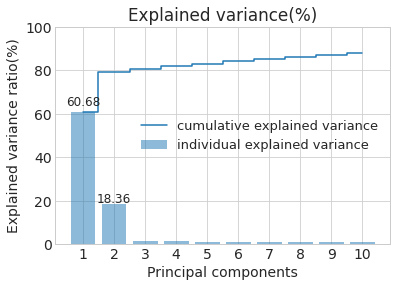

In [11]:
## Explained variance

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

tot_std = sum(eig_vals_std)
var_exp_std = [(i / tot_std)*100 for i in sorted(eig_vals_std, reverse=True)]
cum_var_exp_std = np.cumsum(var_exp_std)

with plt.style.context('seaborn-whitegrid'):
    fig,ax1 = plt.subplots()
    barPlot = ax1.bar(range(10), var_exp_std[:10], alpha=0.5, align='center', label='individual explained variance')
    ax1.step(range(10), cum_var_exp_std[:10], where='mid', label='cumulative explained variance')
    ax1.set_title('Explained variance(%)')
    ax1.set_ylabel('Explained variance ratio(%)')
    ax1.set_xlabel('Principal components')
    ax1.set_xticks(np.arange(0,10,1)), ax1.set_xticklabels(np.arange(1,11,1))
    ax1.set_ylim(0,100)
    ax1.legend(loc='right', fontsize=13)
    ## Show the values on the bars with variance greater than or equal to 10%:
    labelBar = barPlot.datavalues[barPlot.datavalues>=10]
    for i in range(len(labelBar)):
        ax1.text(ax1.patches[i].get_x()+ax1.patches[i].get_width()/2 ,labelBar[i]*1.05,"{:.2f}%".format(labelBar[i]), ha="center",size=12)
        
var_exp_std

In [12]:
# Projection matrix


matrix_w_std = np.hstack((eig_pairs_std[0][1].reshape(33,1),eig_pairs_std[1][1].reshape(33,1)))
Y_std = X_std.dot(matrix_w_std)


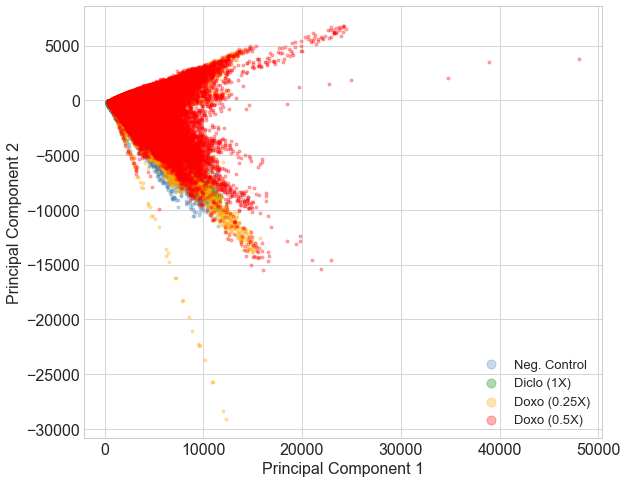

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

with plt.style.context('seaborn-whitegrid'): 
    fig,ax = plt.subplots(figsize=(9,7))
    for lab, col in zip(('control', 'diclo1x', 'doxo025x', 'doxo05x'),
                        ('steelblue', 'green', 'orange','red')):
        ax.scatter(Y_std[y==lab, 0], Y_std[y==lab, 1], label=lab, c=col, marker=".", alpha=0.3)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend(['Neg. Control','Diclo (1X)','Doxo (0.25X)','Doxo (0.5X)'],loc='lower right', fancybox=True, fontsize=13, markerscale=3)
    fig.tight_layout()
    plt.show()

In [14]:
# Create a DataFrame from the projected data for plotting

dfY = pd.DataFrame(Y_std, columns=['pc1','pc2'])
dfY['class'] = y


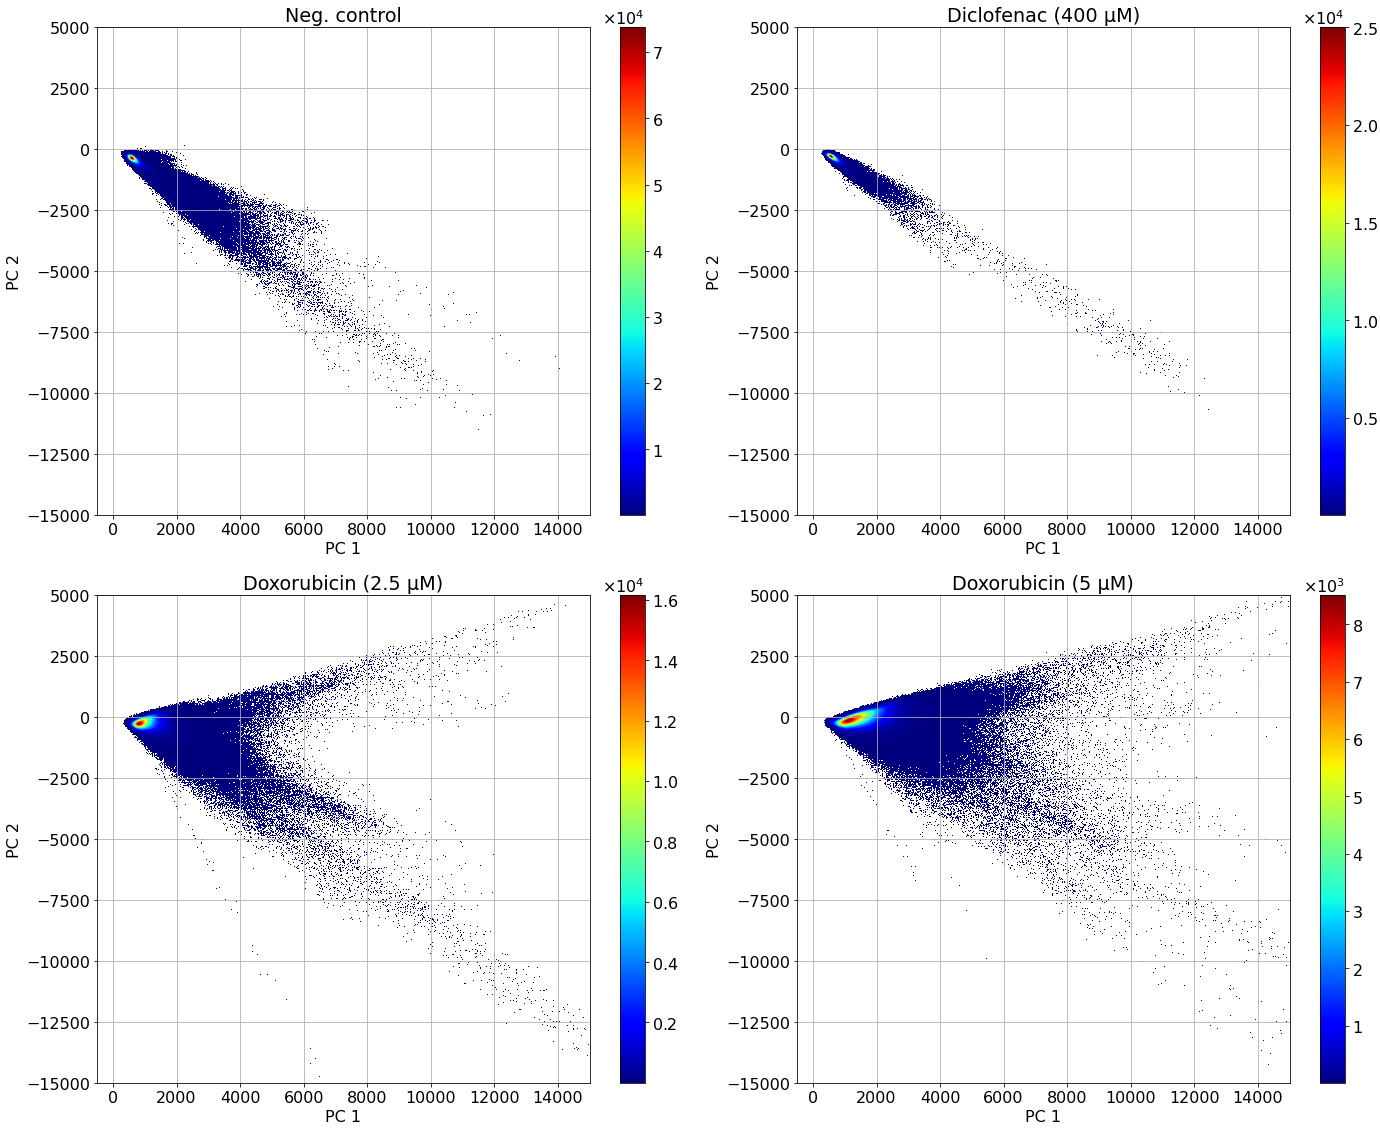

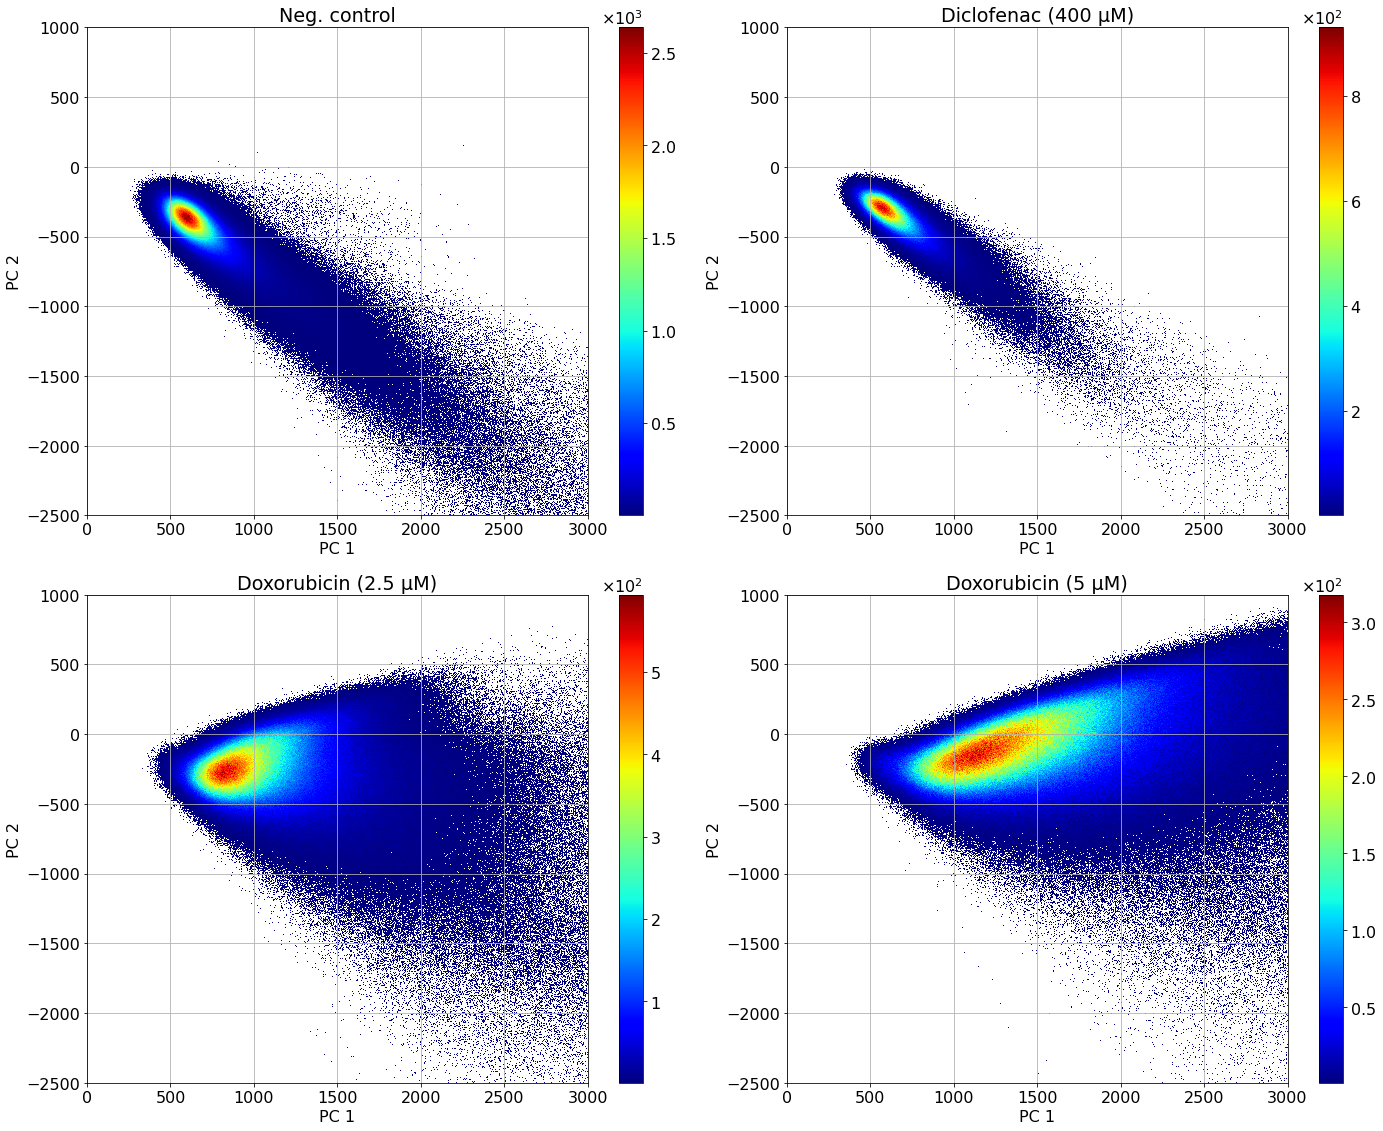

In [15]:
# import mpl_scatter_density
import datashader as ds
from datashader.mpl_ext import dsshow
# from matplotlib.colors import LogNorm
from matplotlib import colors
from matplotlib import ticker

fig = plt.figure(figsize=(20,16))

classDict = dict([('control','Neg. control'),('diclo1x','Diclofenac (400 µM)'),('doxo025x','Doxorubicin (2.5 µM)'),('doxo05x','Doxorubicin (5 µM)')])

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

for i, lab in zip(range(4),('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax = fig.add_subplot(2,2,i+1)
    densityPlot = dsshow(dfY[dfY["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax)
    # ax.set_xlim(-180,10),ax.set_xticks([-175,-150,-125,-100,-75,-50,-25,0])
    # ax.set_ylim(-430,50),ax.set_yticks([-400,-350,-300,-250,-200,-150,-100,-50,0])
    
    ax.set_ylim(-15000,5000)#,ax.set_xticks([-175,-150,-125,-100,-75,-50,-25,0])
    ax.set_xlim(-500,15000)#,ax.set_yticks([-400,-350,-300,-250,-200,-150,-100,-50,0])
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    # ax.set_ylim(yLim[i+1])
    # ax.set_xlim(-175,10)
    ax.set_title(classDict[lab])
    ax.grid(True)
    cbar = fig.colorbar(densityPlot, format=fmt)
    
    # cbar.formatter.set_powerlimits((-2, 2))
    # cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    
fig.tight_layout()

plt.show()
# fig.savefig("densityPlot_0103.png")

fig2 = plt.figure(figsize=(20,16))
for i, lab in zip(range(4), ('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax2 = fig2.add_subplot(2,2,i+1)
    densityPlot2 = dsshow(dfY[dfY["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax2)
    ax2.set_xlim(0,3000)
    ax2.set_ylim(-2500,1000)
    ax2.set_xlabel('PC 1'), ax2.set_ylabel('PC 2')
    ax2.set_title(classDict[lab])
    ax2.grid(True)
    cbar = fig2.colorbar(densityPlot2, format=fmt)
fig2.tight_layout()
plt.show()
# fig2.savefig("densityPlot2_0103.png")

In [18]:
y.shape

(10626302,)

In [19]:
from sklearn.decomposition import PCA
from sklearn import datasets
# from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import copy

yNum = copy.deepcopy(y)
yNum[yNum=='control'] = 1
yNum[yNum=='diclo1x'] = 2
yNum[yNum=='doxo025x'] = 3
yNum[yNum=='doxo05x'] = 4
yNum = yNum.astype('int32')

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit(X, yNum).transform(X)

dfXpca = pd.DataFrame(X_pca, columns=['pc1','pc2'])
dfXpca['class'] = y
dfXlda = pd.DataFrame(X_lda, columns=['pc1','pc2'])
dfXlda['class'] = y

array([1, 1, 1, ..., 4, 4, 4])

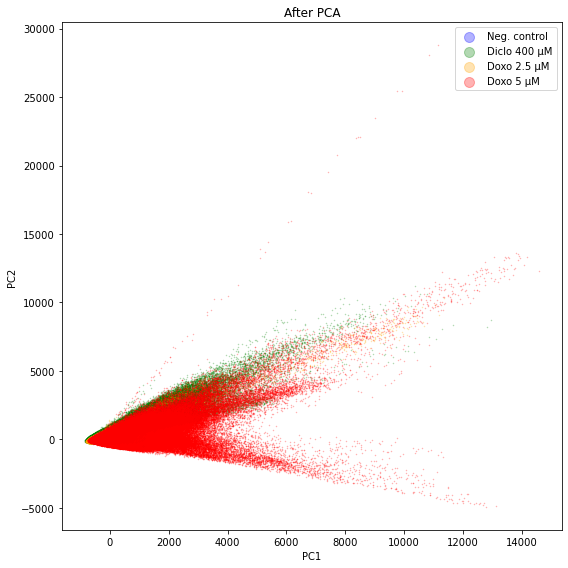

In [23]:
import matplotlib.pyplot as plt

# with plt.style.context('seaborn-whitegrid'): 
#     fig, ax = plt.subplots(figsize=(9,7))
#     for lab, col in zip(('control', 'diclo1x', 'doxo025x', 'doxo05x'),
#                         ('steelblue', 'green', 'orange','red')):
#         ax.scatter(X_pca[y==lab, 0], X_pca[y==lab, 1], label=lab, c=col, marker=".", alpha=0.3)
#     ax.set_xlabel('Principal Component 1')
#     ax.set_ylabel('Principal Component 2')
#     ax.legend(['Neg. Control','Diclo (1X)','Doxo (0.25X)','Doxo (0.5X)'],loc='lower right', fancybox=True, fontsize=13, markerscale=3)
#     fig.tight_layout()
#     fig2, ax2 = plt.subplots(figsize=(9,7))
#     for lab, col in zip(('control', 'diclo1x', 'doxo025x', 'doxo05x'),
#                         ('steelblue', 'green', 'orange','red')):
#         ax2.scatter(X_lda[y==lab, 0], X_lda[y==lab, 1], label=lab, c=col, marker=".", alpha=0.3)
#     ax2.set_xlabel('Principal Component 1')
#     ax2.set_ylabel('Principal Component 2')
#     ax2.legend(['Neg. Control','Diclo (1X)','Doxo (0.25X)','Doxo (0.5X)'],loc='lower right', fancybox=True, fontsize=13, markerscale=3)
#     fig2.tight_layout()
#     plt.show()

fig, ax = plt.subplots(figsize=(8,8))
for i, lab, col in zip(range(4),['Neg. control', 'Diclo 400 µM', 'Doxo 2.5 µM', 'Doxo 5 µM'], ['blue','green','orange','red']):
    ax.scatter(X_pca[yNum==i,0], X_pca[yNum==i,1], c=col, label=lab, marker='.', s=1, alpha=0.3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('After PCA')
ax.legend(markerscale=20)
fig.tight_layout()
plt.show()

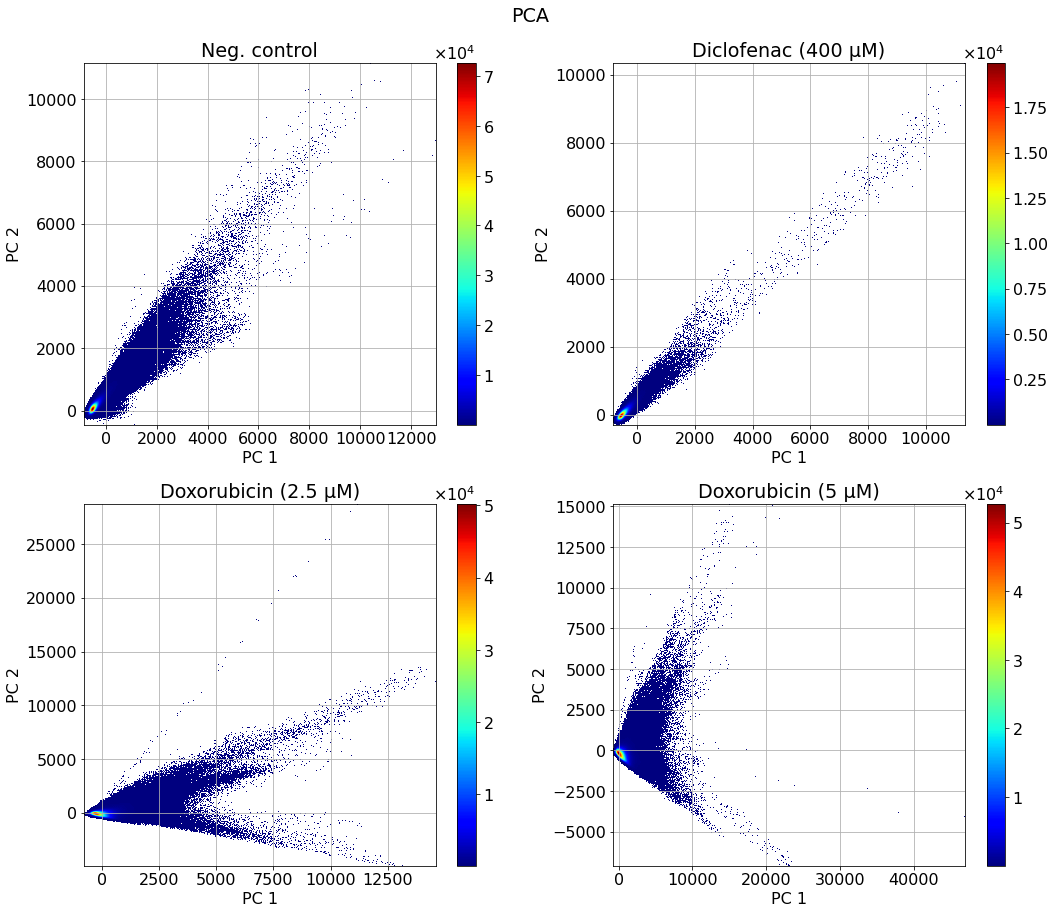

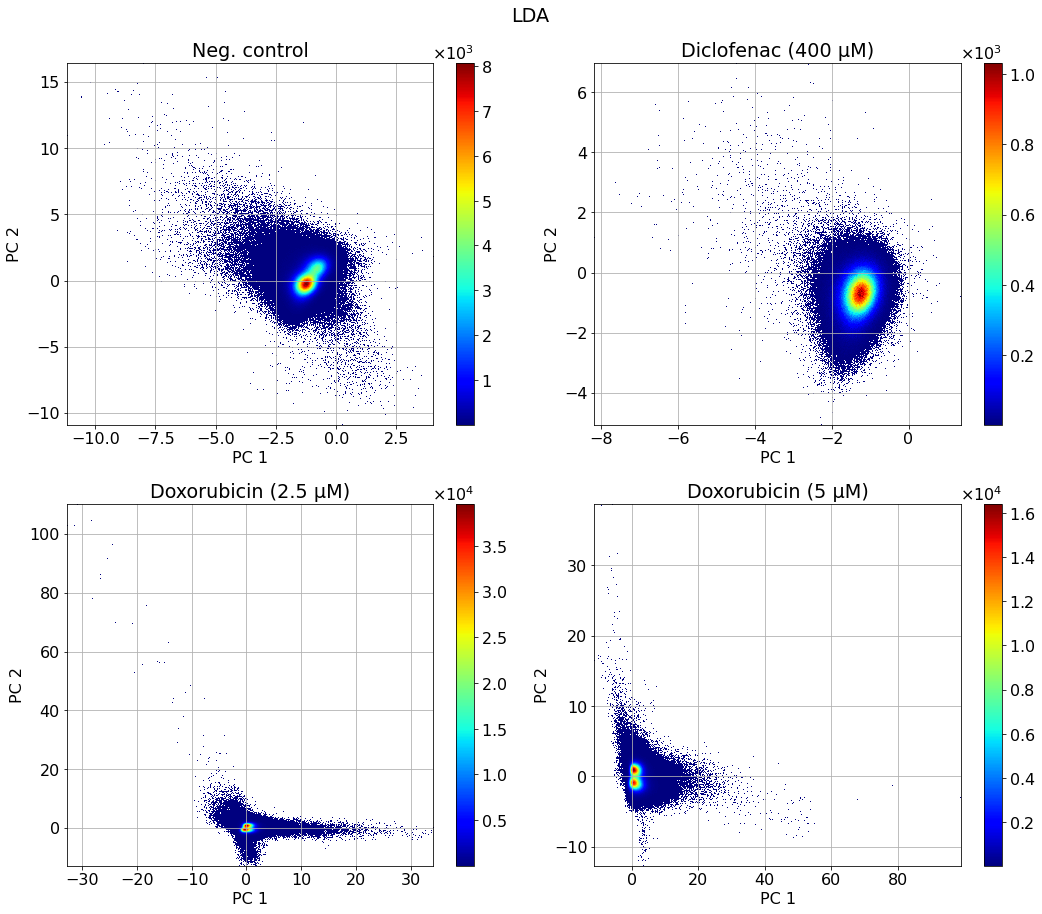

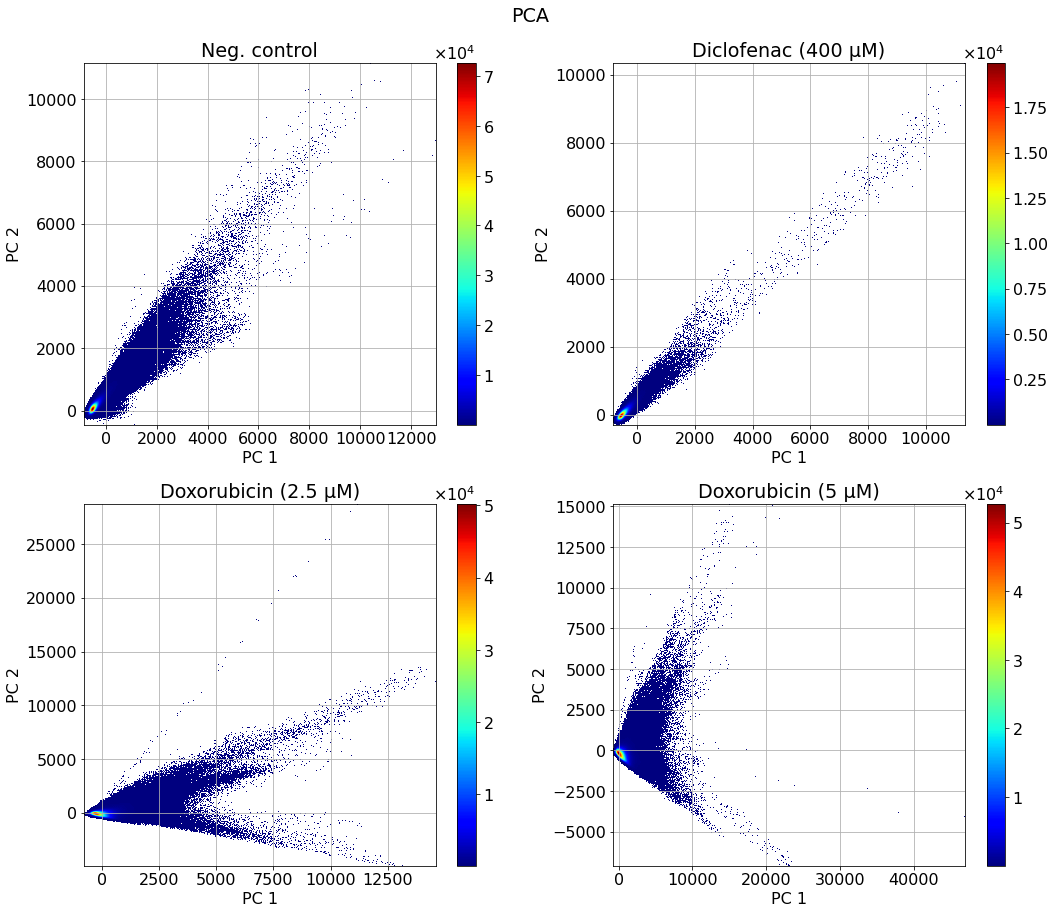

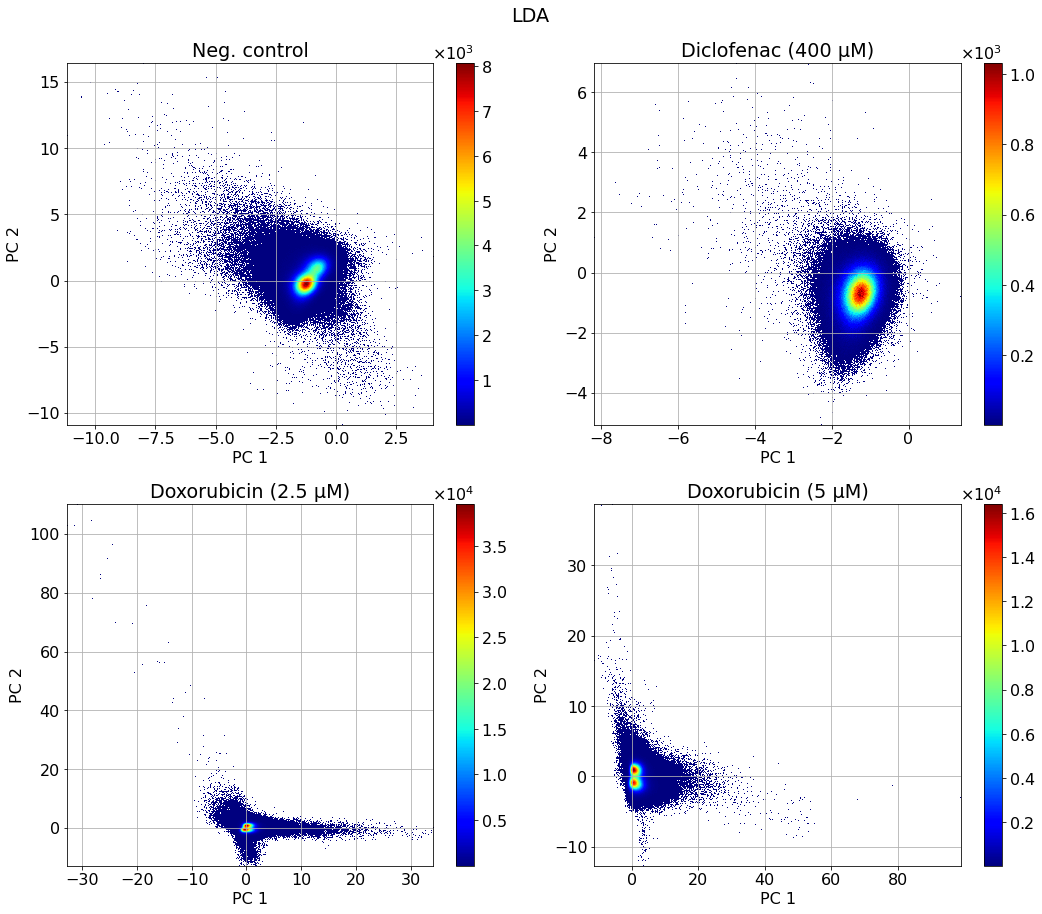

In [23]:
import datashader as ds
from datashader.mpl_ext import dsshow
# from matplotlib.colors import LogNorm
from matplotlib import colors
from matplotlib import ticker

fig = plt.figure(figsize=(15,13))

classDict = dict([('control','Neg. control'),('diclo1x','Diclofenac (400 µM)'),('doxo025x','Doxorubicin (2.5 µM)'),('doxo05x','Doxorubicin (5 µM)')])

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

for i, lab in zip(range(4),('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax = fig.add_subplot(2,2,i+1)
    densityPlot = dsshow(dfXpca[dfXpca["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax)    
    # ax.set_ylim(-5000,20000)#,ax.set_xticks([-175,-150,-125,-100,-75,-50,-25,0])
    # ax.set_xlim(-1000,25000)#,ax.set_yticks([-400,-350,-300,-250,-200,-150,-100,-50,0])
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    # ax.set_ylim(yLim[i+1])
    # ax.set_xlim(-175,10)
    ax.set_title(classDict[lab])
    ax.grid(True)
    cbar = fig.colorbar(densityPlot, format=fmt)
    # cbar.formatter.set_powerlimits((-2, 2))
    # cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
fig.suptitle('PCA')
fig.tight_layout()
plt.show()
fig3 = plt.figure(figsize=(15,13))
# fig.savefig("densityPlot_0103.png")
for i, lab in zip(range(4),('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax3 = fig3.add_subplot(2,2,i+1)
    densityPlot = dsshow(dfXlda[dfXlda["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax3)    
    # ax3.set_ylim(-5000,20000)#,ax3.set_xticks([-175,-150,-125,-100,-75,-50,-25,0])
    # ax3.set_xlim(-1000,25000)#,ax3.set_yticks([-400,-350,-300,-250,-200,-150,-100,-50,0])
    ax3.set_xlabel('PC 1')
    ax3.set_ylabel('PC 2')
    # ax3.set_ylim(yLim[i+1])
    # ax3.set_xlim(-175,10)
    ax3.set_title(classDict[lab])
    ax3.grid(True)
    cbar = fig3.colorbar(densityPlot, format=fmt)
    # cbar.formatter.set_powerlimits((-2, 2))
    # cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
fig3.suptitle('LDA')
fig3.tight_layout()
plt.show()

fig2 = plt.figure(figsize=(15,13))
for i, lab in zip(range(4), ('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax2 = fig2.add_subplot(2,2,i+1)
    densityPlot2 = dsshow(dfXpca[dfXpca["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax2)
    # ax2.set_xlim(0,4000)
    # ax2.set_ylim(-1000,2500)
    ax2.set_xlabel('PC 1'), ax2.set_ylabel('PC 2')
    ax2.set_title(classDict[lab])
    ax2.grid(True)
    cbar = fig2.colorbar(densityPlot2, format=fmt)
fig2.suptitle('PCA')
fig2.tight_layout()
plt.show()

fig4 = plt.figure(figsize=(15,13))
for i, lab in zip(range(4), ('control', 'diclo1x', 'doxo025x', 'doxo05x')):
    ax4 = fig4.add_subplot(2,2,i+1)
    densityPlot2 = dsshow(dfXlda[dfXlda["class"]==lab], ds.Point('pc1','pc2'), ds.count(), cmap='jet', aspect='auto', ax=ax4)
    # ax4.set_xlim(0,4000)
    # ax4.set_ylim(-1000,2500)
    ax4.set_xlabel('PC 1'), ax4.set_ylabel('PC 2')
    ax4.set_title(classDict[lab])
    ax4.grid(True)
    cbar = fig4.colorbar(densityPlot2, format=fmt)
fig4.suptitle('LDA')
fig4.tight_layout()
plt.show()
# fig2.savefig("densityPlot2_0103.png")

In [5]:
# X.dtype
u,s,v = np.linalg.svd(X.T)

MemoryError: Unable to allocate 822. TiB for an array with shape (10626302, 10626302) and data type float64